In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [80]:
df = pd.read_csv('df_final.csv')
df = df.rename(columns={'Unnamed: 0': 'Fecha'})
df['Fecha'] = pd.to_datetime(df['Fecha'])
df.set_index('Fecha', inplace=True)

In [81]:
# ELimino variables para poder hacer los test de significancia
df = df.iloc[:, np.r_[0:2,7:14]]
print(df.shape)

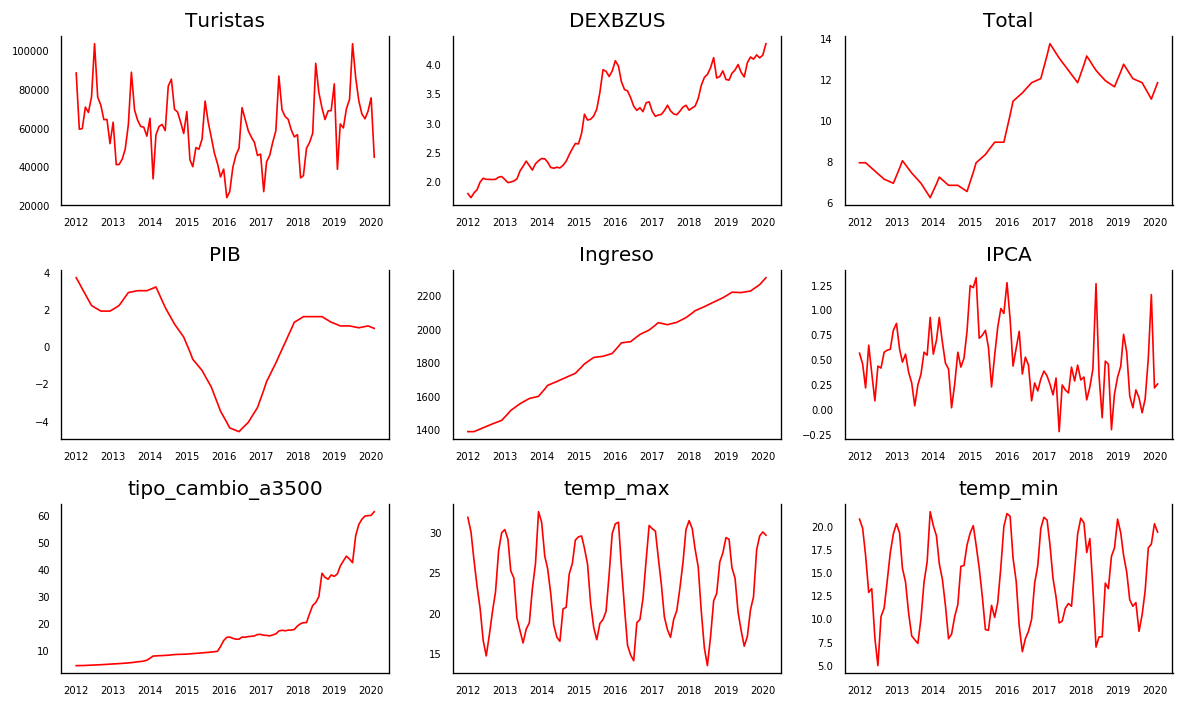

In [83]:
# Se grafican todas las series de tiempo

fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

# Test de causalidad de Granger

The basis behind Vector AutoRegression is that each of the time series in the system influences each other. That is, you can predict the series with past values of itself along with other series in the system.

Using Granger’s Causality Test, it’s possible to test this relationship before even building the model.

Granger’s causality tests the null hypothesis that the coefficients of past values in the regression equation is zero.

In simpler terms, the past values of time series (X) do not cause the other series (Y). So, if the p-value obtained from the test is lesser than the significance level of 0.05, then, you can safely reject the null hypothesis.

In [85]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns) 

,Turistas_x,DEXBZUS_x,Total_x,PIB_x,Ingreso_x,IPCA_x,tipo_cambio_a3500_x,temp_max_x,temp_min_x
Turistas_y,1.0000,0.0010,0.0000,0.0021,0.0000,0.0003,0.0009,0.0000,0.0000
DEXBZUS_y,0.0004,1.0000,0.6480,0.0278,0.0380,0.0000,0.0001,0.3626,0.0019
Total_y,0.0000,0.0043,1.0000,0.0000,0.0168,0.0000,0.1569,0.0000,0.0000
PIB_y,0.3965,0.1607,0.0000,1.0000,0.0088,0.0000,0.1599,0.0681,0.8204
Ingreso_y,0.0000,0.0056,0.0001,0.8214,1.0000,0.0002,0.0796,0.0000,0.0000
IPCA_y,0.0042,0.0003,0.0058,0.0019,0.0713,1.0000,0.0295,0.0015,0.0000
tipo_cambio_a3500_y,0.0311,0.1639,0.1492,0.1938,0.3190,0.0010,1.0000,0.1497,0.0308
temp_max_y,0.0002,0.0091,0.0001,0.0250,0.0159,0.0413,0.2682,1.0000,0.0164
temp_min_y,0.0007,0.0036,0.0007,0.4680,0.0009,0.0236,0.1483,0.0000,1.0000


If a given p-value is < significance level (0.05), then, the corresponding X series (column) causes the Y (row). Looking at the P-Values in the above table, you can pretty much observe that all the variables (time series) in the system are interchangeably causing each other.

This makes this system of multi time series a good candidate for using VAR models to forecast.

# Test de Cointegración

Cointegration test helps to establish the presence of a statistically significant connection between two or more time series.

Order of integration(d) is nothing but the number of differencing required to make a non-stationary time series stationary.

Now, when you have two or more time series, and there exists a linear combination of them that has an order of integration (d) less than that of the individual series, then the collection of series is said to be cointegrated.

When two or more time series are cointegrated, it means they have a long run, statistically significant relationship.

This is the basic premise on which Vector Autoregression(VAR) models is based on. So, it’s fairly common to implement the cointegration test before starting to build VAR models.

In [86]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Turistas ::  400.69    > 179.5199  =>   True
DEXBZUS ::  290.65    > 143.6691  =>   True
Total  ::  212.04    > 111.7797  =>   True
PIB    ::  156.02    > 83.9383   =>   True
Ingreso ::  102.8     > 60.0627   =>   True
IPCA   ::  59.15     > 40.1749   =>   True
tipo_cambio_a3500 ::  28.62     > 24.2761   =>   True
temp_max ::  13.76     > 12.3212   =>   True
temp_min ::  1.68      > 4.1296    =>   False


En el analisis de cointegracion se obtiene que todas las variables son significativas a excepcion de la temperatura minima asi que se la excluye del analisis.

In [94]:
df = df.iloc[:,0:8]

# Separación Test y Train

In [96]:
# Se usan los ultimos 12 meses disponibles desde Febrero 2019 a Febrero 2020 para test
nobs = 12
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
#print(df_train.shape)  # (86, 9)
#print(df_test.shape)  # (12, 9)

In [97]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [98]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Turistas" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.5037
 No. Lags Chosen       = 12
 Critical value 1%     = -3.523
 Critical value 5%     = -2.902
 Critical value 10%    = -2.588
 => P-Value = 0.5317. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "DEXBZUS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3557
 No. Lags Chosen       = 3
 Critical value 1%     = -3.513
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.6033. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Total" 
    -----------------------------------------------
 Null Hypothesis: Data ha

Como dan no estacionarias se hace la diferenciación y se ve si son estacionarias luego de este proceso

In [99]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [100]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Turistas" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.2175
 No. Lags Chosen       = 12
 Critical value 1%     = -3.525
 Critical value 5%     = -2.903
 Critical value 10%    = -2.589
 => P-Value = 0.2. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "DEXBZUS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.1194
 No. Lags Chosen       = 2
 Critical value 1%     = -3.513
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0009. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Total" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationa

Se diferencian de nuevo

In [101]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [102]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Turistas" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.2349
 No. Lags Chosen       = 12
 Critical value 1%     = -3.526
 Critical value 5%     = -2.903
 Critical value 10%    = -2.589
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DEXBZUS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.7814
 No. Lags Chosen       = 4
 Critical value 1%     = -3.516
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Total" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level  

In [103]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [104]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Turistas" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.2212
 No. Lags Chosen       = 12
 Critical value 1%     = -3.527
 Critical value 5%     = -2.904
 Critical value 10%    = -2.589
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "DEXBZUS" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.3647
 No. Lags Chosen       = 5
 Critical value 1%     = -3.518
 Critical value 5%     = -2.9
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Total" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    

https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/